## **Identifying Key Contributors to Road Traffic Accidents Using XGBoost and Exploratory Data Analysis**
### Objectives
* To explore and analyze road traffic crash data to understand patterns and trends in accidents.
* To develop a predictive machine learning model to classify accident severity levels.
* To evaluate the performance of the predictive model using appropriate metrics such as accuracy, precision, recall, and F1-score.
* To provide data-driven recommendations for improving road safety and reducing accident severity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-darkgrid')
sns.set_style('darkgrid', {'axes.facecolor':'0.9'})

In [2]:
crashes=pd.read_csv('./data/Traffic_Crashes_-_Crashes.csv.gz')
people=pd.read_csv('./data/Traffic_Crashes_-_People.csv.gz')
vehicles=pd.read_csv('./data/Traffic_Crashes_-_Vehicles.csv.gz')

c:\Users\Victor\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\Users\Victor\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (20,39,40,41,47,48,49,57,58,60) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54959 entries, 0 to 54958
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CRASH_RECORD_ID                54959 non-null  object 
 1   CRASH_DATE_EST_I               3503 non-null   object 
 2   CRASH_DATE                     54959 non-null  object 
 3   POSTED_SPEED_LIMIT             54959 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         54959 non-null  object 
 5   DEVICE_CONDITION               54959 non-null  object 
 6   WEATHER_CONDITION              54959 non-null  object 
 7   LIGHTING_CONDITION             54959 non-null  object 
 8   FIRST_CRASH_TYPE               54959 non-null  object 
 9   TRAFFICWAY_TYPE                54959 non-null  object 
 10  LANE_CNT                       6 non-null      float64
 11  ALIGNMENT                      54959 non-null  object 
 12  ROADWAY_SURFACE_COND           54959 non-null 

In [4]:
crashes.columns

Index(['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LATITUDE', 

In [36]:
crashes.CRASH_MONTH.value_counts()

8     10191
7      9825
10     9051
9      9039
11     8521
12     8332
Name: CRASH_MONTH, dtype: int64

In [5]:
crashes.INJURIES_FATAL.value_counts()

0.0    54807
1.0       41
2.0        6
Name: INJURIES_FATAL, dtype: int64

In [6]:
vehicles.columns

Index(['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'CRASH_DATE', 'UNIT_NO',
       'UNIT_TYPE', 'NUM_PASSENGERS', 'VEHICLE_ID', 'CMRC_VEH_I', 'MAKE',
       'MODEL', 'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT',
       'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER',
       'TOWED_I', 'FIRE_I', 'OCCUPANT_CNT', 'EXCEED_SPEED_LIMIT_I', 'TOWED_BY',
       'TOWED_TO', 'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I',
       'AREA_04_I', 'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I',
       'AREA_09_I', 'AREA_10_I', 'AREA_11_I', 'AREA_12_I', 'AREA_99_I',
       'FIRST_CONTACT_POINT', 'CMV_ID', 'USDOT_NO', 'CCMC_NO', 'ILCC_NO',
       'COMMERCIAL_SRC', 'GVWR', 'CARRIER_NAME', 'CARRIER_STATE',
       'CARRIER_CITY', 'HAZMAT_PLACARDS_I', 'HAZMAT_NAME', 'UN_NO',
       'HAZMAT_PRESENT_I', 'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO',
       'MCS_REPORT_I', 'MCS_REPORT_NO', 'HAZMAT_VIO_CAUSE_CRASH_I',
       'MCS_VIO_CAUSE_CRASH_I', 'IDOT_PERMIT_NO', 'WIDE_LOAD_I',
       'TRAILER1_

In [7]:
people.columns

Index(['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'VEHICLE_ID',
       'CRASH_DATE', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE',
       'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT',
       'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'HOSPITAL',
       'EMS_AGENCY', 'EMS_RUN_NO', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY',
       'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE',
       'CELL_PHONE_USE'],
      dtype='object')

In [41]:
people.DRIVER_ACTION.value_counts()

NONE                                 32986
UNKNOWN                              25952
OTHER                                10155
FAILED TO YIELD                       8617
FOLLOWED TOO CLOSELY                  4791
IMPROPER LANE CHANGE                  2546
IMPROPER TURN                         2417
IMPROPER BACKING                      2400
IMPROPER PASSING                      2337
DISREGARDED CONTROL DEVICES           1735
TOO FAST FOR CONDITIONS               1039
WRONG WAY/SIDE                         437
OVERCORRECTED                          357
IMPROPER PARKING                       348
CELL PHONE USE OTHER THAN TEXTING      119
EVADING POLICE VEHICLE                 110
EMERGENCY VEHICLE ON CALL               92
TEXTING                                 25
STOPPED SCHOOL BUS                      15
LICENSE RESTRICTIONS                     3
Name: DRIVER_ACTION, dtype: int64

In [8]:
people.CRASH_RECORD_ID.duplicated().sum()

65207

In [9]:
vehicles.CRASH_RECORD_ID.duplicated().sum()

56768

In [ ]:
crashes.CRASH_RECORD_ID.duplicated().sum()I. 

0

In [11]:
vehicle_agg = vehicles.groupby('CRASH_RECORD_ID').agg({
    'VEHICLE_TYPE': 'nunique',
    'OCCUPANT_CNT': 'sum',
    'VEHICLE_DEFECT': lambda x: (x != 'NONE').sum()
}).reset_index()


In [12]:
vehicle_agg.VEHICLE_DEFECT.value_counts()

2     20783
0     16948
1     15680
3      1241
4       229
5        55
6        17
7         3
13        1
11        1
8         1
Name: VEHICLE_DEFECT, dtype: int64

In [13]:
vehicle_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54959 entries, 0 to 54958
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CRASH_RECORD_ID  54959 non-null  object 
 1   VEHICLE_TYPE     54959 non-null  int64  
 2   OCCUPANT_CNT     54959 non-null  float64
 3   VEHICLE_DEFECT   54959 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 1.7+ MB


In [14]:
people.INJURY_CLASSIFICATION.value_counts()

NO INDICATION OF INJURY     107043
NONINCAPACITATING INJURY      6729
REPORTED, NOT EVIDENT         5296
INCAPACITATING INJURY          927
FATAL                           53
Name: INJURY_CLASSIFICATION, dtype: int64

In [15]:
people_agg = people.groupby('CRASH_RECORD_ID').agg({
    'AGE': 'mean',
    'SAFETY_EQUIPMENT': lambda x: ((x == 'SAFETY BELT USED') | 
                                   (x == 'BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)') |
                                   (x == 'CHILD RESTRAINT - REAR FACING') |
                                   (x == 'CHILD RESTRAINT - FORWARD FACING') |
                                   (x == 'BOOSTER SEAT')).sum(),
    'INJURY_CLASSIFICATION': lambda x: (x == 'FATAL').sum()
}).reset_index()

people_agg['INJURY_CLASSIFICATION'] = (people_agg['INJURY_CLASSIFICATION'] > 0).astype(int)

In [16]:
people_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54854 entries, 0 to 54853
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CRASH_RECORD_ID        54854 non-null  object 
 1   AGE                    45740 non-null  float64
 2   SAFETY_EQUIPMENT       54854 non-null  int64  
 3   INJURY_CLASSIFICATION  54854 non-null  int32  
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 1.5+ MB


In [17]:
people_agg.INJURY_CLASSIFICATION.value_counts(normalize=True)

0    0.999143
1    0.000857
Name: INJURY_CLASSIFICATION, dtype: float64

In [18]:
people_agg.AGE.fillna(people_agg.AGE.mean(), inplace=True)

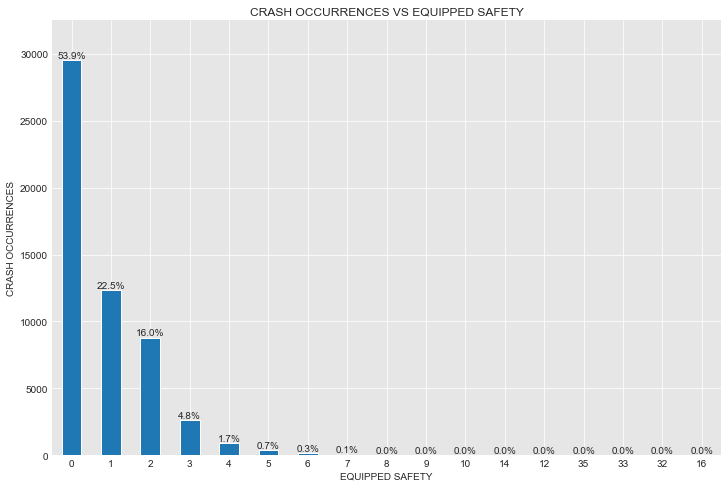

In [31]:
equipment_rates=people_agg.SAFETY_EQUIPMENT.value_counts()
equipment_rates.plot(kind='bar', figsize=(12,8))
plt.title('CRASH OCCURRENCES VS EQUIPPED SAFETY')
plt.xlabel('EQUIPPED SAFETY')
plt.ylabel('CRASH OCCURRENCES')
plt.xticks(rotation=0)

plt.ylim(0, equipment_rates.max() * 1.1)
total = equipment_rates.sum()

for i, rate in enumerate(equipment_rates):
    plt.text(
        i,
        rate,
        f"{rate/total:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    )


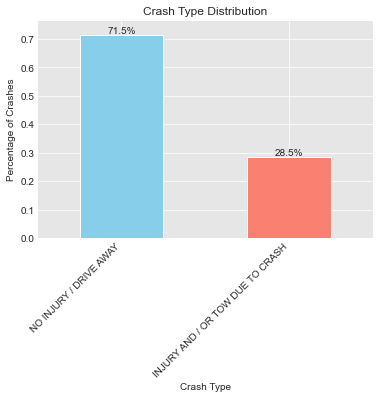

In [ ]:
crash_type = crashes['CRASH_TYPE'].value_counts(normalize=True)
# Bar plot
crash_rates.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Crash Type Distribution')
plt.xlabel('Crash Type')
plt.ylabel('Percentage of Crashes')
plt.ylim(0, crash_rates.max() + 0.05)
plt.xticks(rotation=45, ha='right')
# Add percentage labels on bars
for i, rate in enumerate(crash_rates):
    plt.text(
        i,
        rate + 0.005,
        f"{rate:.1%}",
        ha='center',
        fontsize=10
    );

In [40]:
crashes.STREET_NAME.value_counts()

WESTERN AVE        1579
CICERO AVE         1250
PULASKI RD         1245
ASHLAND AVE        1162
HALSTED ST         1003
                   ... 
MOFFAT ST             1
HARBOR AVE            1
COULTER ST            1
NASSAU AVE            1
COLUMBUS SUB DR       1
Name: STREET_NAME, Length: 1236, dtype: int64

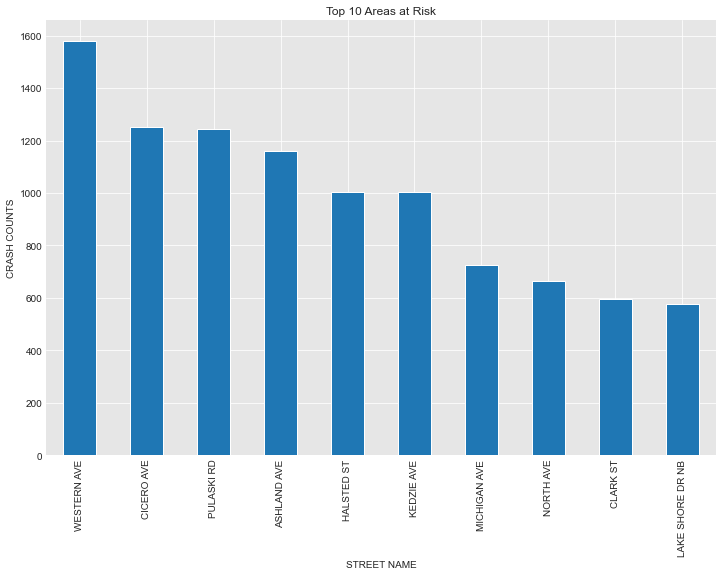

In [ ]:
# top 10 areas at risk
top_10_risk_areas = crashes.STREET_NAME.value_counts().head(10)
top_10_risk_areas.plot(kind='bar', figsize=(12,8))
plt.title('Top 10 Areas at Risk')
plt.ylabel('CRASH COUNTS')
plt.xlabel('STREET NAME');